In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scripts.drawer import russia_plots
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pickle
# import seaborn as sns
from tqdm.notebook import tqdm
from scripts.drawer import metric_viewer

gauges_file = gpd.read_file('../geo_data/great_db/geometry/russia_gauges.gpkg')
ws_file = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')
ws_file = ws_file.set_index('gauge_id')
basemap_data = gpd.read_file('../geo_data/great_db/geometry/russia_forest_25people.geojson')

### Russia geom

In [5]:
test_gauges = pd.read_csv('./data/basins_test.txt', names=['gauge_id'])
test_gauges['gauge_id'] = test_gauges['gauge_id'].astype(str)
train_gauges = pd.read_csv('./data/basins_train.txt', names=['gauge_id'])
train_gauges['gauge_id'] = train_gauges['gauge_id'].astype(str)
val_gauges = pd.read_csv('./data/basins_val.txt', names=['gauge_id'])
val_gauges['gauge_id'] = val_gauges['gauge_id'].astype(str)

for i, val in enumerate(gauges_file.loc[:, 'gauge_id']):
    
    if val in test_gauges['gauge_id'].values:
        gauges_file.loc[i, 'status'] = 'test'
    elif val in train_gauges['gauge_id'].values:
        gauges_file.loc[i, 'status'] = 'train'
    elif val in val_gauges['gauge_id'].values:
        gauges_file.loc[i, 'status'] = 'val'
    else:
        gauges_file.loc[i, 'status'] = np.NaN
gauges_file

gauge_id                         name_ru  \
0        9002              р.Енисей - г.Кызыл   
1        9022         р.Енисей - пос.Никитино   
2        9053          р.Енисей - пос.Базаиха   
3        9112  р.Большой Енисей - с.Тоора-Хем   
4        9115    р.Большой Енисей - пос.Сейба   
...       ...                             ...   
2075    11056            р.Иртыш - г.Тобольск   
2076    11061      р.Иртыш - г.Ханты-Мансийск   
2077    11801              р.Обь - г.Салехард   
2078    10031             р.Обь - с.Белогорье   
2079     2027               р.Берш - с.Пущино   

                              name_en     new_area  ais_dif  \
0                  r.Enisej - g.Kyzyl   115263.989    0.230   
1             r.Enisej - pos.Nikitino   184499.118    1.373   
2              r.Enisej - pos.Bazaiha   302690.417    0.897   
3     r.Bol'shoj Enisej - s.Toora-Hem    15448.834    0.969   
4       r.Bol'shoj Enisej - pos.Sejba    44934.891    0.751   
...                               ...          ...      ...   
2075            r.Irtysh - g.Tobol'sk  1540451.386    2.697   
2076      r.Irtysh - g.Hanty-Mansijsk  1694019.131    2.668   
2077               r.Ob' - g.Salehard  3004250.818    1.839   
2078              r.Ob' - s.Belogor'e  2738297.601    1.795   
2079             r.Bersh - s.Puschino       67.694    3.843   

                                               geometry status  
0     POLYGON ((96.87792 53.72792, 96.87792 53.72708...    NaN  
1     POLYGON ((96.87792 53.72708, 96.88042 53.72708...    NaN  
2     POLYGON ((92.38292 56.11042, 92.38292 56.10958...    NaN  
3     POLYGON ((97.07125 52.71625, 97.07125 52.71542...  train  
4     POLYGON ((96.87792 53.72708, 96.88042 53.72708...  train  
...                                                 ...    ...  
2075  POLYGON ((65.28125 59.37208, 65.28125 59.37125...    NaN  
2076  POLYGON ((62.66375 61.80542, 62.66542 61.80542...    NaN  
2077  POLYGON ((66.69042 66.42875, 66.69042 66.42792...    NaN  
2078  POLYGON ((74.80958 63.03958, 74.80958 63.03875...    NaN  
2079  POLYGON ((157.97708 54.05625, 157.97792 54.056...    val  

[2080 rows x 7 columns]

<class 'geopandas.geodataframe.GeoDataFrame'>


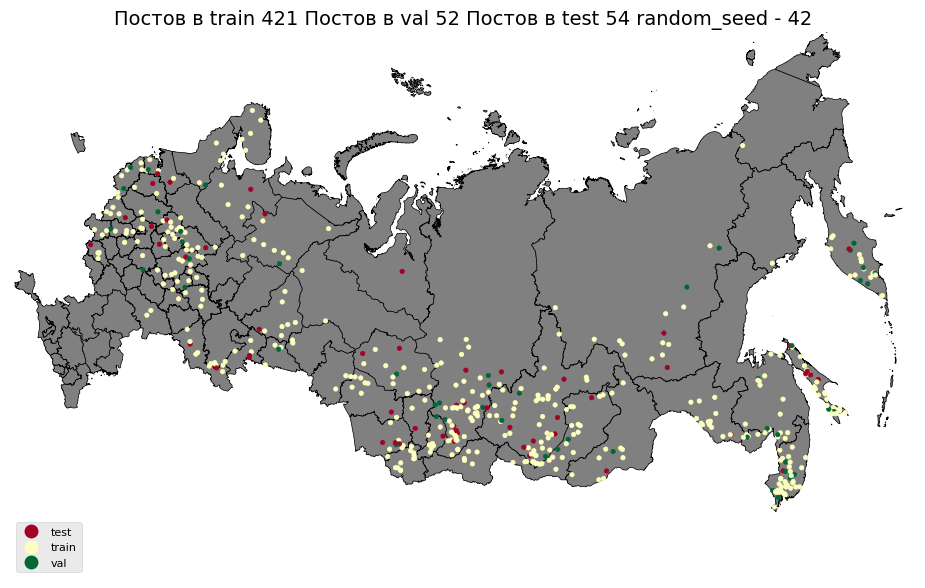

In [143]:
gauges_fig = russia_plots(gdf_to_plot=gauges_file.dropna(),
                          basemap_data=basemap_data,
                          distinction_col='status',
                          title_text=f"""Постов в train {len(train_gauges)}\
 Постов в val {len(val_gauges)}\
 Постов в test {len(test_gauges)}\
 random_seed - 42""",
                          just_points=True);


In [6]:
q_obs = {'full': list(),
         'partial': list(),
         'empty': list()}
h_obs = {'full': list(),
         'partial': list(),
         'empty': list()}

def nan_fractor(df_col: pd.Series):
    nan_frac = df_col.isna().sum() / len(df_col)
    return nan_frac

nc_cond = [file.split('/')[-1][:-3] for file
           in glob.glob('../geo_data/great_db/nc_concat/*.nc')]

for file in glob.glob('../geo_data/great_db/ais_data/q_h/*.csv'):
    gauge_id = file.split('/')[-1][:-4]
    if gauge_id in nc_cond:
        test = pd.read_csv(file, index_col='date')
        lvls = test[['lvl_sm', 'lvl_mbs']]
        dschrg = test[['q_cms_s', 'q_mm_day']]
        
        fraction_of_nan_q = dschrg['q_cms_s'].isna().sum() / len(dschrg)
        
        if fraction_of_nan_q == 0.0:
            q_obs['full'].append(gauge_id)
        elif fraction_of_nan_q <= 0.25:
            q_obs['partial'].append(gauge_id)
        elif fraction_of_nan_q > 0.25:
            q_obs['empty'].append(gauge_id)
            
        fraction_of_nan_h = lvls['lvl_mbs'].isna().sum() / len(lvls)
        
        if fraction_of_nan_h == 0.0:
            h_obs['full'].append(gauge_id)
        elif fraction_of_nan_h <= 0.25:
            h_obs['partial'].append(gauge_id)
        elif fraction_of_nan_h > 0.25:
            h_obs['empty'].append(gauge_id)
    else:
        continue


In [10]:
[len(val) for val in h_obs.values()]

[1554, 467, 50]

In [11]:
[len(val) for val in q_obs.values()]

[1226, 506, 339]

### Plots for discharges

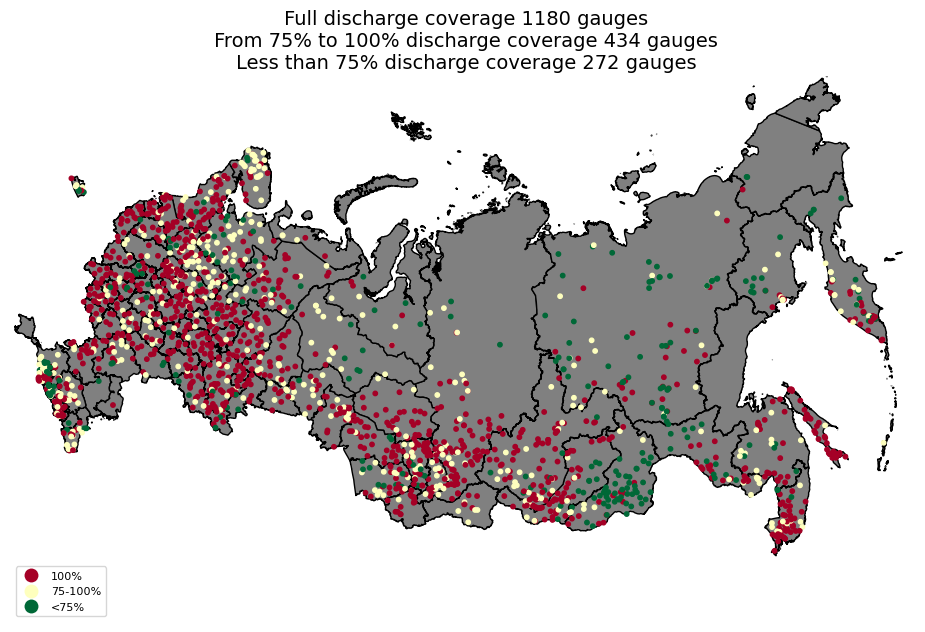

In [7]:
gauges_file = gpd.read_file('../geo_data/great_db/geometry/russia_gauges.gpkg')
for i, val in enumerate(gauges_file.loc[:, 'gauge_id']):
    
    if val in q_obs['full']:
        gauges_file.loc[i, 'status'] = '100%'
    elif val in q_obs['partial']:
        gauges_file.loc[i, 'status'] = '75-100%'
    elif val in q_obs['empty']:
        gauges_file.loc[i, 'status'] = '<75%'

gauges_fig = russia_plots(gdf_to_plot=gauges_file,
                          basemap_data=basemap_data,
                          distinction_col='status',
                          title_text=f"""\
 Full discharge coverage {len(q_obs['full'])} gauges\n\
 From 75% to 100% discharge coverage {len(q_obs['partial'])} gauges\n\
 Less than 75% discharge coverage {len(q_obs['empty'])} gauges""",
                          just_points=True);

In [10]:
gauges_file[gauges_file['status'] == '75-100%'].to_file('../geo_data/great_db/geometry/gauges_partial_q.gpkg')

### Levels

<class 'geopandas.geodataframe.GeoDataFrame'>


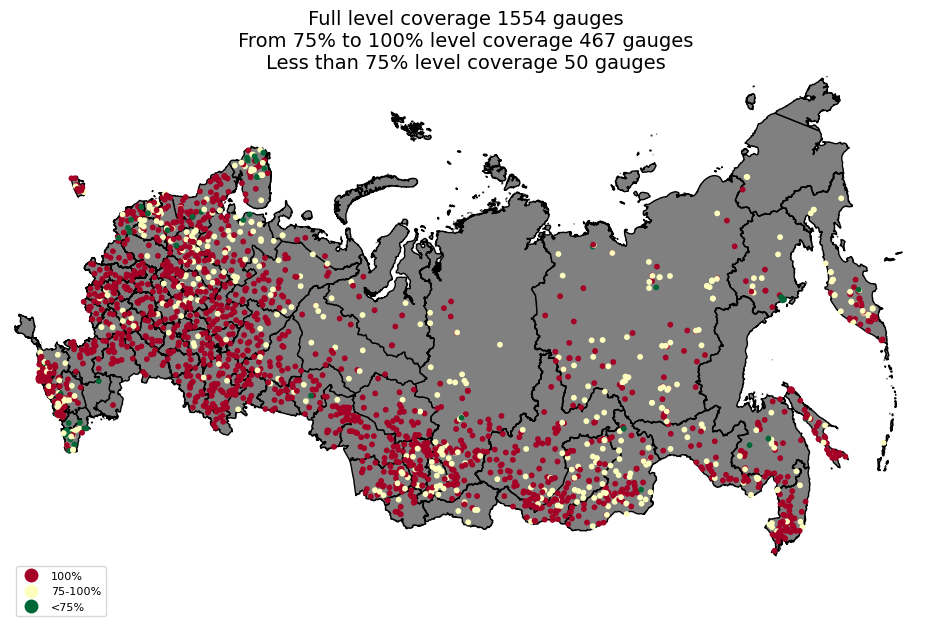

In [23]:
gauges_file = gpd.read_file('../geo_data/great_db/geometry/russia_gauges.gpkg')

for i, val in enumerate(gauges_file.loc[:, 'gauge_id']):
    
    if val in h_obs['full']:
        gauges_file.loc[i, 'status'] = '100%'
    elif val in h_obs['partial']:
        gauges_file.loc[i, 'status'] = '75-100%'
    elif val in h_obs['empty']:
        gauges_file.loc[i, 'status'] = '<75%'

gauges_fig = russia_plots(gdf_to_plot=gauges_file,
                          basemap_data=basemap_data,
                          distinction_col='status',
                          title_text=f"""\
 Full level coverage {len(h_obs['full'])} gauges\n\
 From 75% to 100% level coverage {len(h_obs['partial'])} gauges\n\
 Less than 75% level coverage {len(h_obs['empty'])} gauges""",
                          just_points=True);


### Check model quality

In [ ]:
era5_land_file, nse_median = metric_viewer(
    metric_col='NSE',
    gauges_file=gauges_file,
    metric_csv='../test_meteo_input/runs_static/era5L_static_prcp_0704_170903/test/model_epoch021/test_metrics.csv')
gauges_fig = russia_plots(gdf_to_plot=era5_land_file,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(era5_land_file)} водосборов = {nse_median:.3f}""");

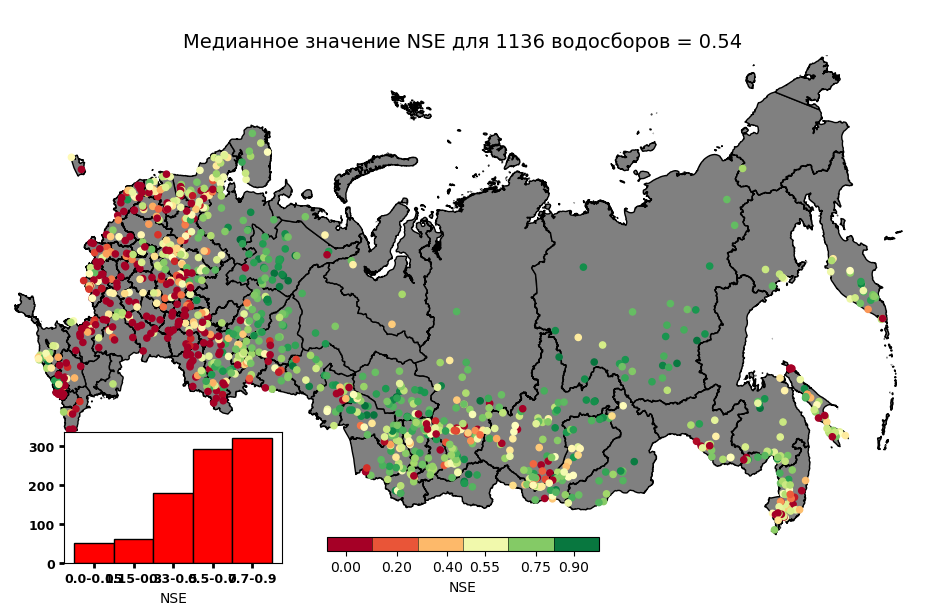

In [17]:
gpcp_file, nse_median = metric_viewer(
    '../test_meteo_input/runs_q_cms/gpcp_prcp_3003_063422/test/model_epoch042/test_metrics.csv')
gauges_fig = russia_plots(gdf_to_plot=gpcp_file,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(gpcp_file)} водосборов = {nse_median:.2f}""");

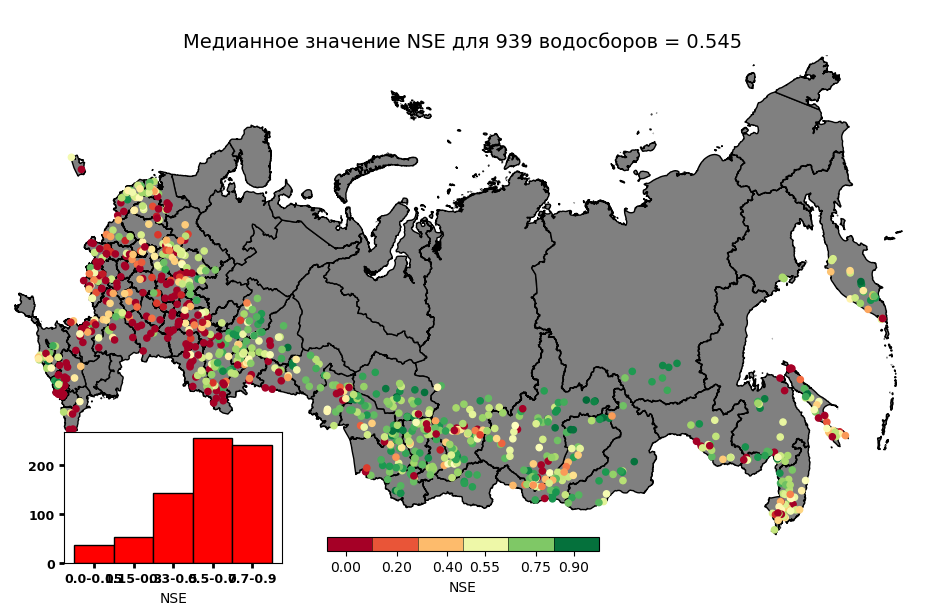

In [20]:
imerg_file, nse_median = metric_viewer(
    '../test_meteo_input/runs_q_cms/imerg_prcp_3003_135405/test/model_epoch042/test_metrics.csv')
gauges_fig = russia_plots(gdf_to_plot=imerg_file,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(imerg_file)} водосборов = {nse_median:.3f}""");

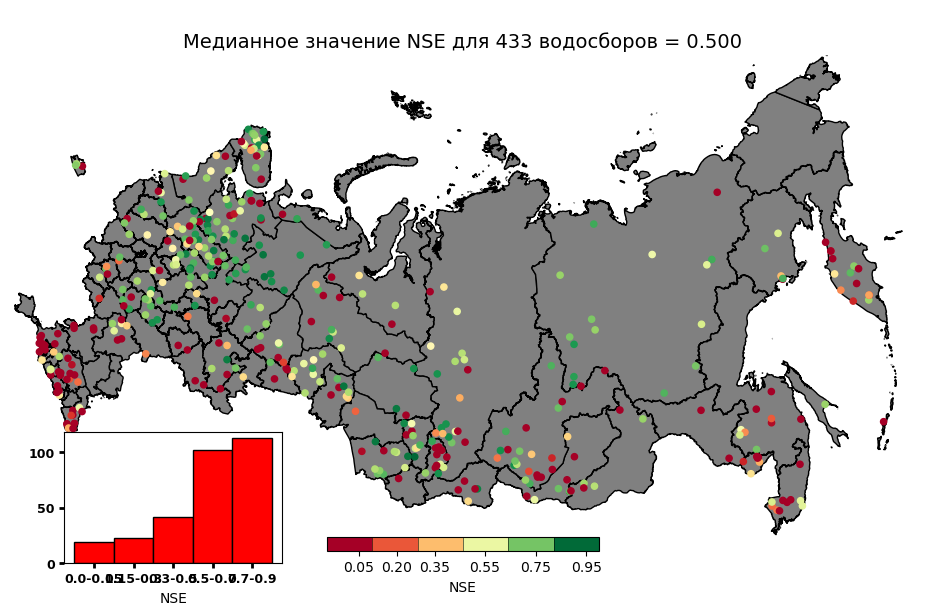

In [3]:
era5_mm, nse_median = metric_viewer(
    gauges_file=gauges_file,
    metric_col='NSE',
    metric_csv='../test_meteo_input/runs_blind/era5L_static_CellsBlind_2004_130807/test/model_epoch024/test_metrics.csv')
gauges_fig = russia_plots(gdf_to_plot=era5_mm,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(era5_mm)} водосборов = {nse_median:.3f}""");

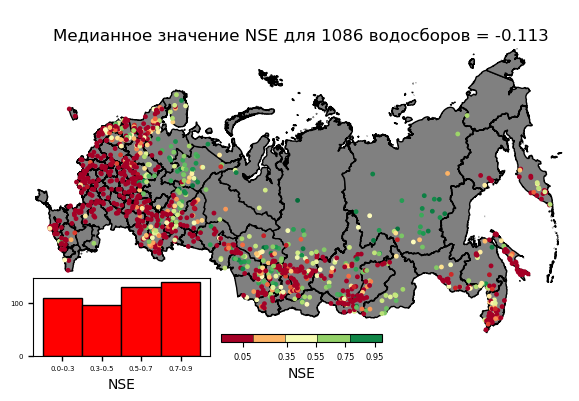

In [5]:
era5_file, nse_median = metric_viewer(
    metric_col='NSE',
    gauges_file=gauges_file,
    metric_csv='../test_meteo_input/runs_static/era5L_static_CellWeights_2004_092936/test/model_epoch024/test_metrics.csv')
gauges_fig = russia_plots(gdf_to_plot=era5_file,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(era5_file)} водосборов = {nse_median:.3f}""");

### Static ERA5-Land

In [4]:
era5_file, nse_median = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5L_static_prcp_0704_170903/test/model_epoch021/test_metrics.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)
gauges_fig = russia_plots(gdf_to_plot=era5_file,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True)
gauges_fig.savefig('./example.tiff',
                   dpi=650)

FileNotFoundError: [Errno 2] No such file or directory: '../test_meteo_input/runs_static/era5L_static_prcp_0704_170903/test/model_epoch021/test_metrics.csv'

### No-Static ERA5-Land

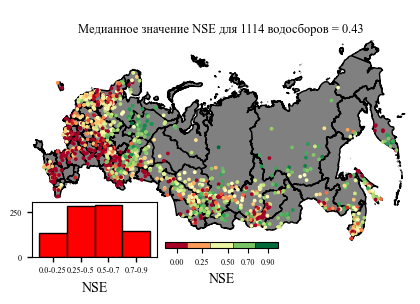

In [24]:
era5_file, nse_median = metric_viewer(metric_csv='/workspaces/my_dissertation/test_meteo_input/runs_no_static/era5Land_prcp_0604_111347/test/model_epoch030/test_metrics.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)
gauges_fig = russia_plots(gdf_to_plot=era5_file,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='NSE',
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(era5_file)} водосборов = {nse_median:.2f}""");
gauges_fig.savefig('./example.tiff',
                   dpi=650)

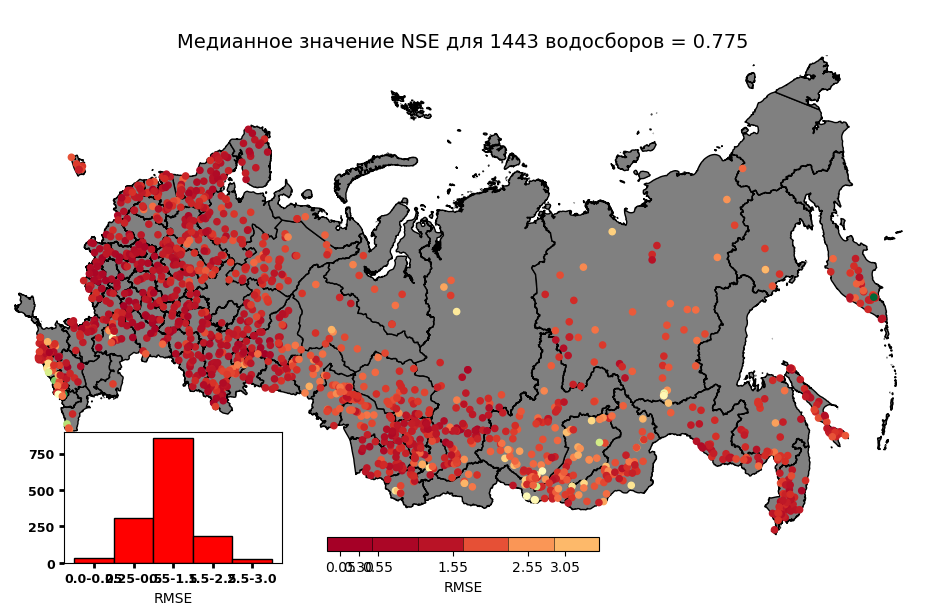

In [21]:
mswep_h_mbs, nse_median = metric_viewer(
    gauges_file=gauges_file,
    metric_csv='/workspaces/my_dissertation/test_meteo_input/runs_h/mswep_lvl_mbs_0304_203329/test/model_epoch021/test_metrics.csv',
    metric_col='RMSE')

gauges_fig = russia_plots(gdf_to_plot=mswep_h_mbs,
                          basemap_data=basemap_data,
                          cmap='RdYlGn',
                          metric_col='RMSE',
                          list_of_limits=[0.00, 0.25, 0.50, 1.50, 2.50, 3.00],
                          distinction_col='',
                          with_histogram=True,
                          title_text=f"""
Медианное значение NSE для {len(mswep_h_mbs)} водосборов = {nse_median:.3f}""");

In [3]:
xr.open_dataset('../geo_data/great_db/nc_all_h/10002.nc')

<xarray.Dataset>
Dimensions:     (date: 4749)
Coordinates:
  * date        (date) datetime64[ns] 2008-01-01 2008-01-02 ... 2020-12-31
    gauge_id    object ...
Data variables: (12/23)
    lvl_sm      (date) float64 ...
    q_cms_s     (date) float64 ...
    lvl_mbs     (date) float64 ...
    q_mm_day    (date) float64 ...
    t_max_e5l   (date) float64 ...
    t_max_e5    (date) float64 ...
    ...          ...
    SMroot      (date) float64 ...
    Ew          (date) float64 ...
    Ei          (date) float64 ...
    S           (date) float64 ...
    E           (date) float64 ...
    Ep          (date) float64 ...

### View BAD results

In [ ]:
for gauge in [gauge.split('/')[-1][:-3]
              for gauge in glob.glob('../geo_data/great_db/nc_all_q/*.nc')]:

    area = ws_file.loc[gauge, 'new_area']
    results = xr.open_dataset(f'../geo_data/great_db/nc_all_q/{gauge}.nc').drop('gauge_id').to_dataframe()[['lvl_sm', 'q_cms_s', 'q_mm_day', 'prcp_e5', 'prcp_e5l', 'prcp_mswep', 'prcp_gpcp']]
    results.to_csv(f'./recovery/{gauge}.csv')
    fig = results[['q_mm_day']].plot(
            figsize=(15, 10),
            fontsize=18).get_figure();
    plt.title(f'{gauge} for catchment with area of {area:.3f}',
              fontsize=20)
    fig.savefig(f"./images/{gauge}.png")
    # plt.show()

### Outlier remover

In [51]:
example_file = pd.read_csv('./recovery/10058.csv',
                           index_col='date')
example_file.index = pd.to_datetime(example_file.index)
example_file

lvl_sm  q_cms_s    q_mm_day   prcp_e5  prcp_e5l  prcp_mswep  \
date                                                                      
2008-01-01    25.0    17.00  100.177329  0.001252  0.004483    0.000000   
2008-01-02    24.0    16.00   94.284545  0.000000  0.003494    0.000000   
2008-01-03    17.0    16.00   94.284545  2.190799  1.011411    0.126885   
2008-01-04    16.0    16.00   94.284545  1.057222  1.675332    0.126885   
2008-01-05    16.0    16.00   94.284545  0.465194  0.252440    0.348934   
...            ...      ...         ...       ...       ...         ...   
2020-12-27    34.0     0.15    0.883918  0.006840  0.027936    0.000000   
2020-12-28    34.0     0.15    0.883918  0.000000  0.001886    0.031721   
2020-12-29    34.0     0.15    0.883918  0.000000  0.002033    0.000000   
2020-12-30    34.0     0.14    0.824990  1.275203  0.672187    0.348934   
2020-12-31    33.0     0.14    0.824990  2.564995  3.084454         NaN   

            prcp_gpcp  
date                   
2008-01-01   0.000000  
2008-01-02   0.000000  
2008-01-03   0.567415  
2008-01-04   0.000000  
2008-01-05   1.233340  
...               ...  
2020-12-27   0.000000  
2020-12-28   0.000000  
2020-12-29   0.000000  
2020-12-30   0.429617  
2020-12-31   4.982376  

[4749 rows x 7 columns]

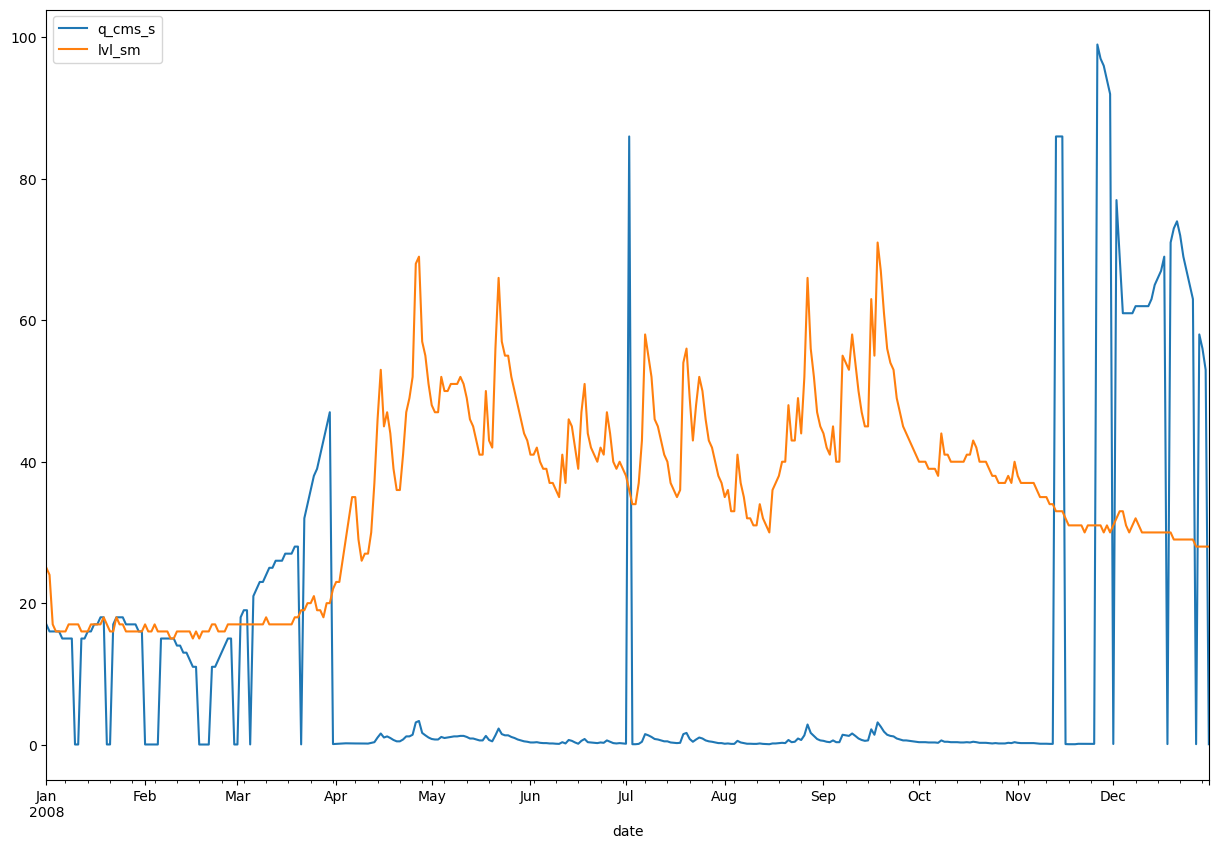

In [64]:
example_file.loc['2008', ['q_cms_s', 'lvl_sm']].plot(figsize=(15, 10));

### Meteo correlation

In [33]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr


def get_r2(df,
           frequency: str,
           prcp_col: str,
           hydro_col: str = 'q_cms_s'):
    df = df.groupby(pd.Grouper(freq=frequency)).sum()
    df = pd.concat([df[prcp_col], df[hydro_col].shift(0)],
                   axis=1).dropna()
    return pearsonr(x=df[hydro_col],
                    y=df[prcp_col])
    
test_df = xr.open_dataset('../geo_data/great_db/nc_all_q/10059.nc')
test_df = test_df.to_dataframe()[['q_cms_s', 'q_mm_day', 'lvl_sm',
                                  'prcp_e5', 'prcp_e5l',
                                  'prcp_gpcp', 'prcp_imerg',
                                  'prcp_mswep']]
get_r2(df=test_df,
       frequency='30D',
       prcp_col='prcp_mswep',
       hydro_col='q_mm_day')[0]

0.6438525831942314

In [ ]:
res_df = list()
for file in tqdm(glob.glob('../geo_data/great_db/nc_all_q/*.nc')):
    
    gauge_id = file.split('/')[-1][:-3]
    test_df = xr.open_dataset(file)
    test_df = test_df.to_dataframe()[['q_cms_s', 'q_mm_day', 'lvl_sm',
                                    'prcp_e5', 'prcp_e5l',
                                    'prcp_gpcp', 'prcp_imerg',
                                    'prcp_mswep']]

    res_df.append(pd.DataFrame({prcp_col: get_r2(df=test_df,
                                frequency='30D',
                                prcp_col=prcp_col,
                                hydro_col='q_mm_day')[0]
    for prcp_col in ['prcp_e5', 'prcp_e5l',
                     'prcp_gpcp', 'prcp_imerg',
                     'prcp_mswep']},
                               index=[gauge_id]))
res_df = pd.concat(res_df)
res_df.index.name = 'gauge_id'

In [73]:
res_df

prcp_e5  prcp_e5l  prcp_gpcp  prcp_imerg  prcp_mswep
gauge_id                                                       
12554     0.051507  0.059747   0.035564    0.024633    0.078539
5746      0.256063  0.255251   0.251723    0.242195    0.241771
8376      0.137983  0.146141   0.149067    0.158665    0.147927
3159      0.051057  0.055564   0.018861         NaN    0.030858
74438     0.047712  0.053672   0.044282    0.045739    0.078507
...            ...       ...        ...         ...         ...
9079      0.276373  0.285451   0.249588         NaN    0.253960
72519    -0.041185 -0.030746  -0.027294   -0.031982   -0.039316
70827     0.111031  0.117411   0.047331         NaN    0.098691
4107      0.118815  0.196898   0.058689    0.060996    0.098787
3001      0.174922  0.190210   0.150703    0.176444    0.108667

[1148 rows x 5 columns]

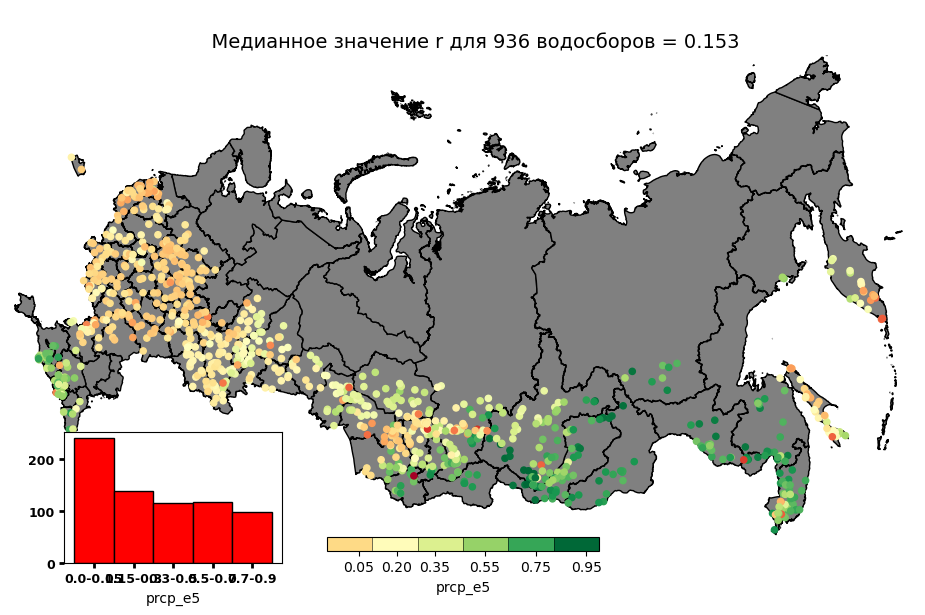

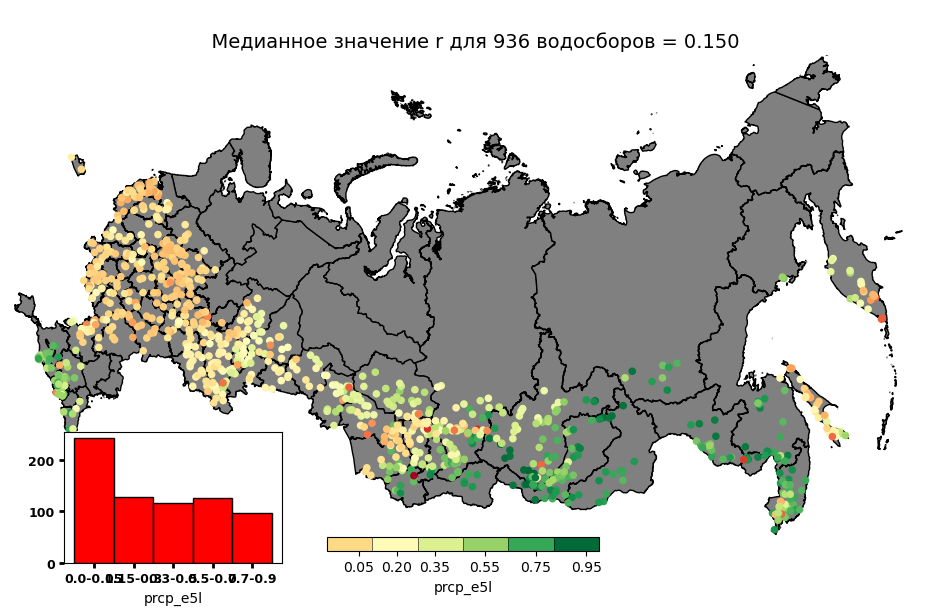

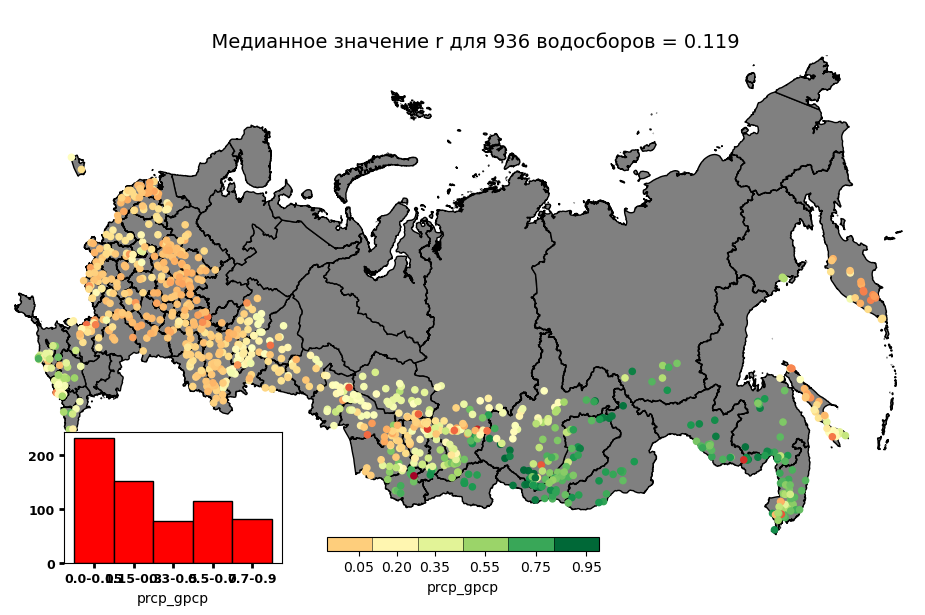

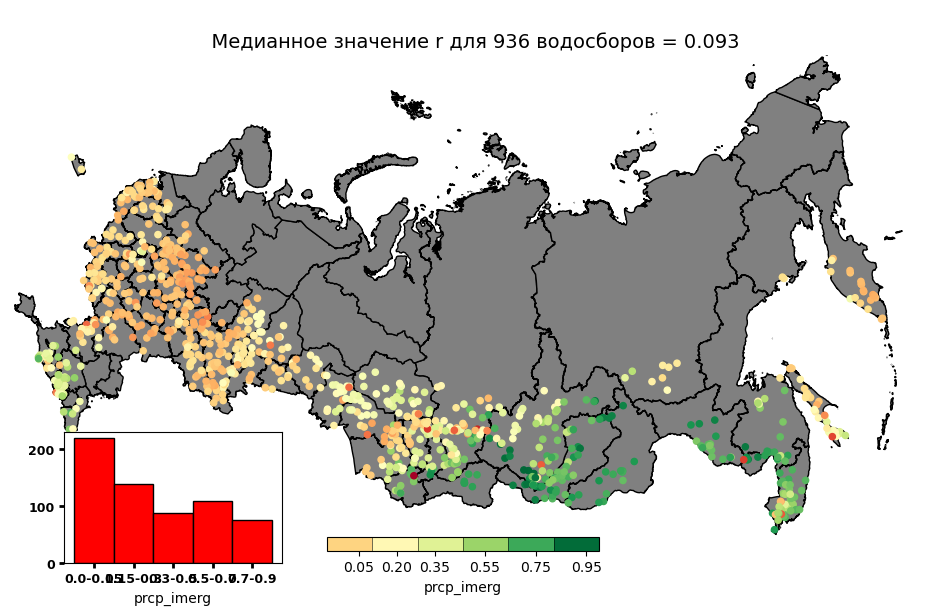

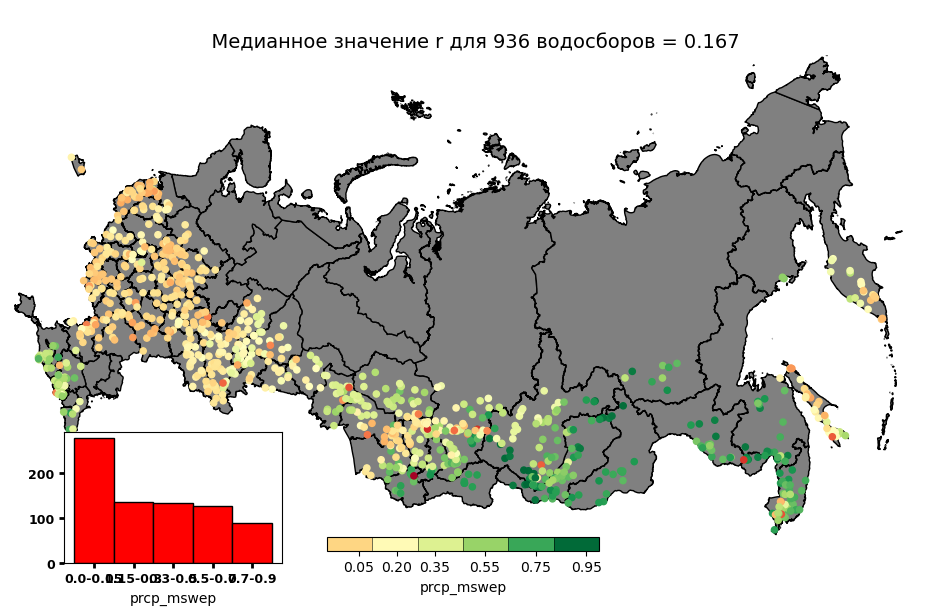

In [24]:
geom_r2 = gauges_file.set_index('gauge_id').join(res_df).dropna()
for prcp_col in ['prcp_e5', 'prcp_e5l',
                 'prcp_gpcp', 'prcp_imerg',
                 'prcp_mswep']:

    r_median = geom_r2[prcp_col].median()
    gauges_fig = russia_plots(gdf_to_plot=geom_r2,
                            basemap_data=basemap_data,
                            cmap='RdYlGn',
                            metric_col=prcp_col,
                            distinction_col='',
                            with_histogram=True,
                            title_text=f"""
    Медианное значение r для {len(geom_r2)} водосборов = {r_median:.3f}""");

### Meteo plots

In [6]:
from pathlib import Path
path_to_store = Path('./meteo_visualisations/')
path_to_store.mkdir(exist_ok=True, parents=True)
from typing import Tuple

def read_maurer(maurer_path: Path, basin: str) -> Tuple[pd.DataFrame, float]:
    """[summary]

    Args:
        basin (str): [description]

    Raises:
        RuntimeError: [description]

    Returns:
        Tuple[pd.DataFrame, float]: [description]
    """

    files = list(maurer_path.glob('**/*_forcing_leap.txt'))
    file_path = [f for f in files if f.name[:8] == basin]
    if len(file_path) == 0:
        raise RuntimeError(f'No file for Basin {basin} at {file_path}')
    else:
        file_path = file_path[0]

    df = pd.read_csv(file_path, sep='\s+', header=3)
    dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/" + df.Day.map(str))
    df['date'] = pd.to_datetime(dates, format="%Y-%m-%d")
    df = df.set_index('date', drop=True)

    # load area from header
    with open(file_path, 'r') as fp:
        content = fp.readlines()
        area = round(float(content[2]), 2)
        area /= 10**6

    return df, area


In [7]:
gauges = list(area_data.index)

In [ ]:
differ_files = dict()

for gauge in tqdm(gauges):
    # read meteo file
    area = area_data.loc[gauge, 'ws_area']
    meteo_maurer, _ = read_maurer(maurer_path=Path(
        './data/CAMELS/basin_mean_forcing/maurer_extended'
    ),
        basin=gauge)
    meteo_era = pd.read_csv(f'./data/CAMELS/forcings/{gauge}.csv')
    meteo_era['date'] = pd.to_datetime(meteo_era['date'])
    meteo_era = meteo_era.set_index('date', drop=True)

    res_file = meteo_era.join(meteo_maurer)
    res_file = res_file['01/01/1980':'12/31/2008']
    res_file = res_file.rename(columns={'prcp(mm/day)': 'prcp',
                                        'srad(W/m2)': 'srad',
                                        'swe(mm)': 'swe',
                                        'tmax(C)': 'tmax',
                                        'tmin(C)': 'tmin',
                                        'vp(Pa)': 'vp'})

    differ_files[gauge] = res_file[['temp_max', 'tmax', 'temp_min',
                                    'tmin', 'precip', 'prcp']]


def get_mae_prcp(gauge):
    precip, prcp = differ_files[gauge][['precip', 'prcp']].groupby(
        pd.Grouper(freq='1Y')).sum().mean().values

    res = prcp - precip
    area = area_data.loc[gauge, 'ws_area']

    return (precip, prcp, area)


fin_res = pd.DataFrame()
for gauge, val in differ_files.items():

    era, maurer, area = get_mae_prcp(gauge)
    fin_res.loc[gauge, 'area'] = area
    fin_res.loc[gauge, 'prcp_Era'] = era
    fin_res.loc[gauge, 'prcp_Maurer'] = maurer

fin_res['area_gradation'] = pd.cut(fin_res['area'],
                                   bins=[0, 250, 500, 1000, 2000, np.inf],
                                   right=False,
                                   include_lowest=False)
# group_fin = fin_res.groupby('area_gradation').mean()
era_df = pd.DataFrame()
era_df = fin_res[['area', 'prcp_Era']]
era_df = era_df.rename(columns={'prcp_Era': 'prcp'})
era_df.loc[:, 'tag'] = 'ERA5'

maurer_df = pd.DataFrame()
maurer_df = fin_res[['area', 'prcp_Maurer']]
maurer_df.loc[:, 'tag'] = 'Maurer'
maurer_df = maurer_df.rename(columns={'prcp_Maurer': 'prcp'})

maurer_vs_era = pd.concat([era_df, maurer_df]).reset_index(drop=True)


In [ ]:
ws = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')

def lim_definer(area: float):

    lim_1, lim_2, lim_3 = 100, 2000, 50000

    if area < lim_1:
        return '< 100 sq. km'
    elif (area >= lim_1) & (area <= lim_2):
        return '100 sq. km - 2 000 sq.km'
    elif (area >= lim_2) & (area <= lim_3):
        return '2 000 sq. km - 50 000 sq.km'
    else:
        return '> 50 000 sq.km'


ws['size'] = ws.loc[:, 'new_area'].apply(lambda x: lim_definer(x))
ws['size'] = pd.Categorical(ws['size'], ['< 100 sq. km',
                                         '100 sq. km - 2 000 sq.km',
                                         '2 000 sq. km - 50 000 sq.km',
                                         '> 50 000 sq.km'])


plt.figure(figsize=(15, 8))

area_hist = sns.histplot(data=ws,
                         x='size')
#  set the ticks first
area_hist.set_yticks(np.arange(0, 1100, 100));
# set the labels
area_hist.set_yticklabels(np.arange(0, 1100, 100));
area_hist.set_xlabel('Area range')
area_hist.set_ylabel('Number of objects')

area_hist.set_title(f"""Distribution of watersheds areas
for every created geometry""", fontsize=16);


In [9]:
fin_res


area     prcp_Era  prcp_Maurer   area_gradation
01013500  2302.903431  1131.943053   986.478621    [2000.0, inf)
01022500   620.423845  1146.762302  1207.854828  [500.0, 1000.0)
01030500  3675.502151  1128.475597  1085.230345    [2000.0, inf)
01031500   766.509220  1176.784675  1161.034483  [500.0, 1000.0)
01047000   904.969099  1178.680671  1152.266207  [500.0, 1000.0)
...               ...          ...          ...              ...
14309500   226.431942  1329.677149  1843.521724     [0.0, 250.0)
14316700   588.244890  1582.616854  1603.937931  [500.0, 1000.0)
14325000   445.160763  1489.699641  2585.008276   [250.0, 500.0)
14362250    43.907511  1022.074773   945.884828     [0.0, 250.0)
14400000   703.850167  1923.778572  3179.853793  [500.0, 1000.0)

[671 rows x 4 columns]

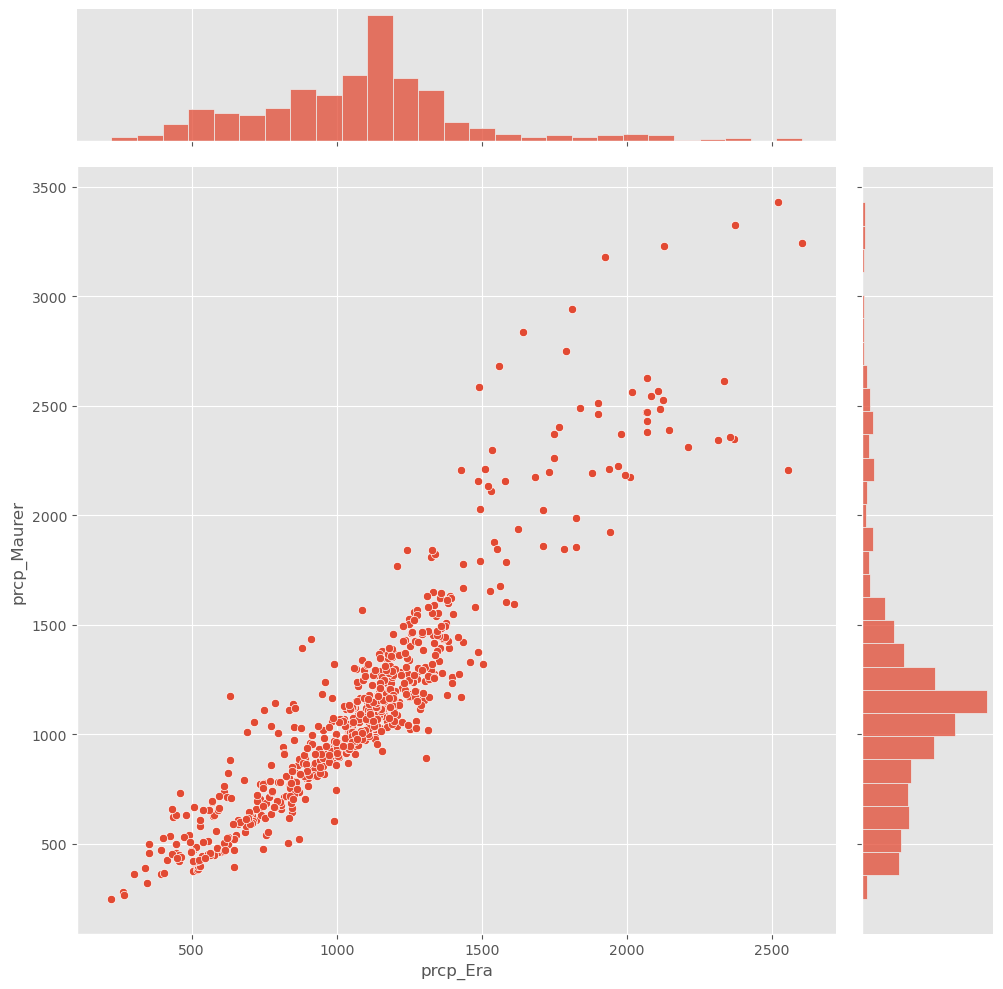

In [8]:
import seaborn as sns
sns.jointplot(data=fin_res, x="prcp_Era", y="prcp_Maurer", height=10);


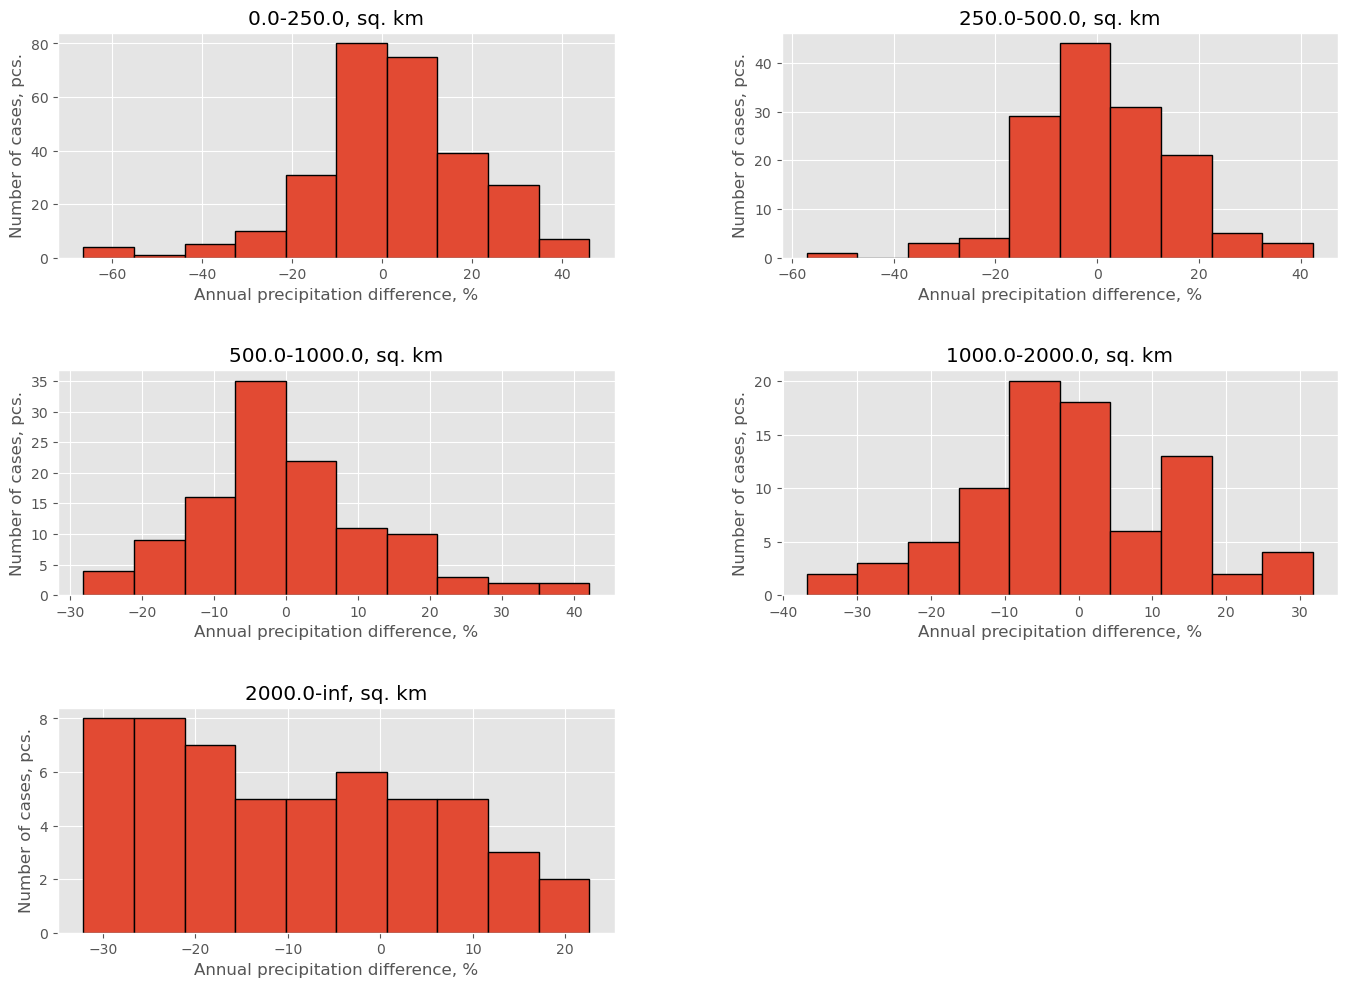

In [11]:
my_hist = fin_res.hist(column='prcp_diff',
                       by='area_gradation',
                       figsize=(16, 12),
                       edgecolor='black', linewidth=1)

xlbl = [str(col)[1:-1].replace(', ', '-')
        for col in np.unique(fin_res['area_gradation'])]
xlbl = [f'{lbl}, sq. km' for lbl in xlbl]

for i, ax in enumerate(my_hist.flatten()[:-1]):
    ax.set_title(xlbl[i])
    ax.set_xlabel("Annual precipitation difference, %")
    ax.set_ylabel('Number of cases, pcs.')
    ax.tick_params(axis='x', labelrotation=0);


In [11]:
from sklearn.metrics import r2_score


def get_r2(precip_df, frequency: str):
    precip_df = precip_df.groupby(pd.Grouper(freq=frequency)).sum()
    return r2_score(y_true=precip_df['prcp'],
                    y_pred=precip_df['precip'])


def value_hist(column_to_plot: str,
               frequency: str,
               xlabel: str):

    fin_res[column_to_plot] = [get_r2(data,
                                  frequency=frequency)
                           for data in differ_files.values()]

    my_hist = fin_res.hist(column=column_to_plot,
                           by='area_gradation',
                           figsize=(16, 12),
                           edgecolor='black', linewidth=1)

    xlbl = [str(col)[1:-1].replace(', ', '-')
            for col in np.unique(fin_res['area_gradation'])]
    xlbl = [f'{lbl}, кв. км' for lbl in xlbl]

    for i, ax in enumerate(my_hist.flatten()[:-1]):
        ax.set_title(xlbl[i])
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Число объектов, шт.')
        ax.tick_params(axis='x', labelrotation=0)


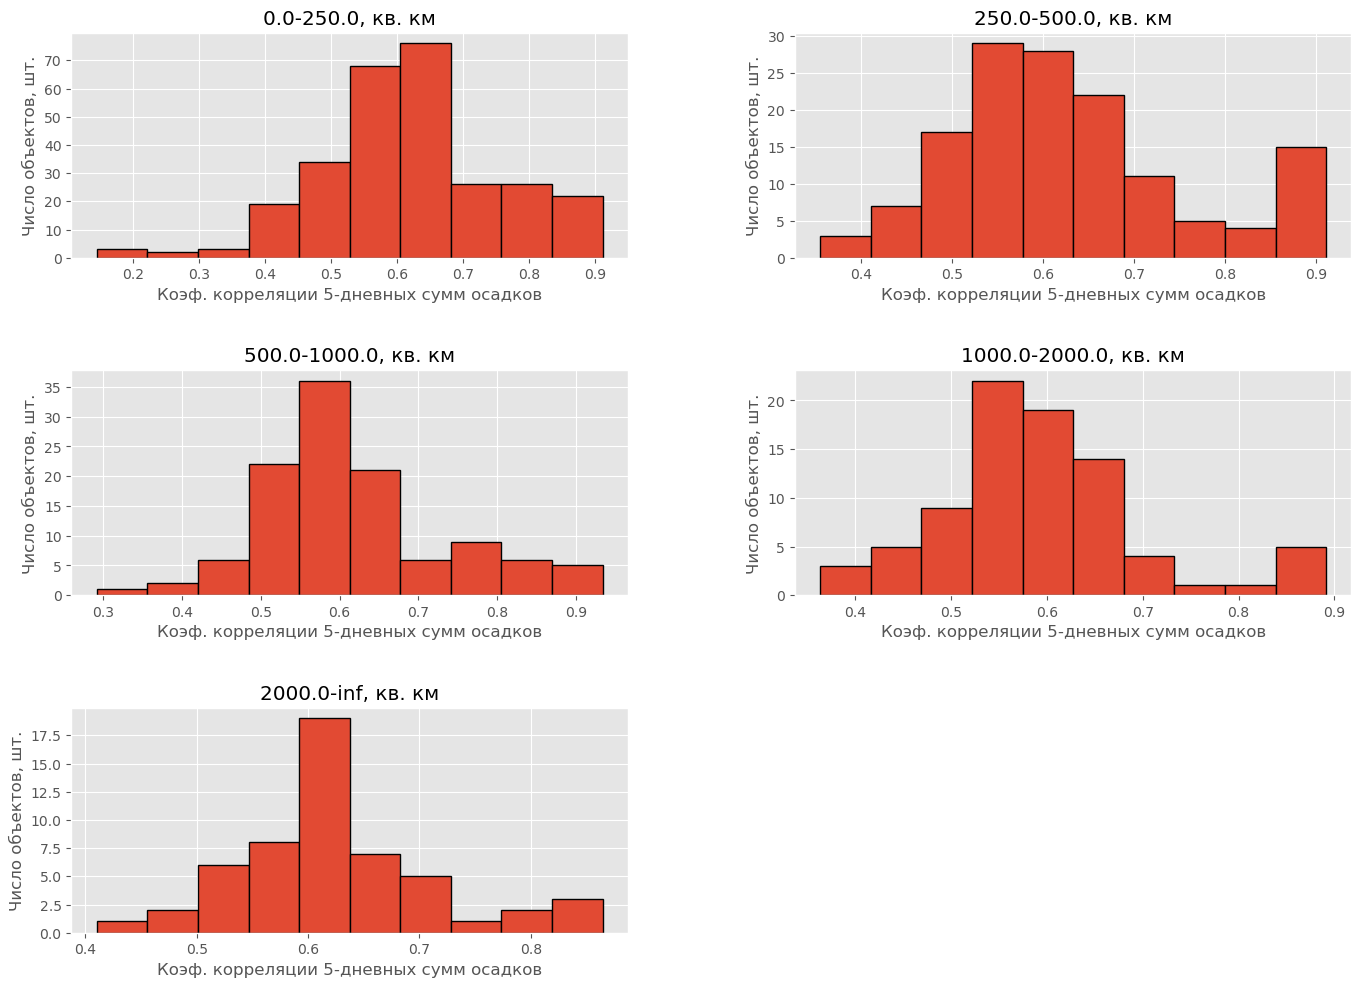

In [12]:
value_hist(column_to_plot='r2_5d',
           frequency='5d',
           xlabel="Коэф. корреляции 5-дневных сумм осадков")

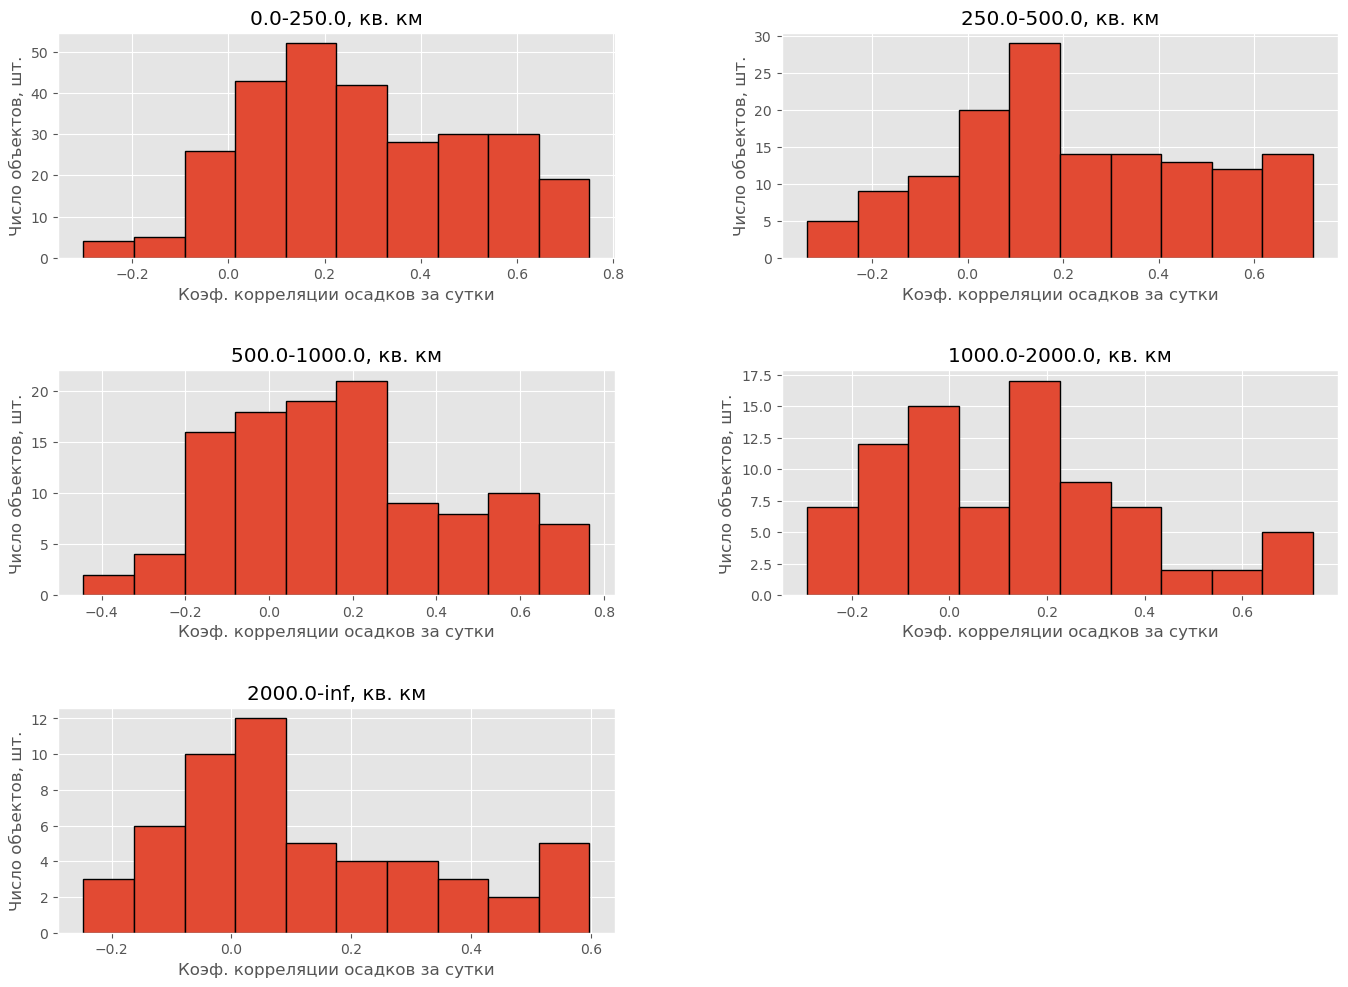

In [13]:
value_hist(column_to_plot='r2_daily',
           frequency='1d',
           xlabel="Коэф. корреляции осадков за сутки")

## Weighted meteo-grid

In [3]:
import random
import sys
sys.path.append('../')
from data_builders.scripts.geom_functions import (create_gdf, polygon_area,
                                                  getSquareVertices,
                                                  poly_from_multipoly,
                                                  find_extent)
from data_builders.scripts.nc_proc import nc_by_extent

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as mticker

import xarray as xr
import dask.config as dask_cfg
from shapely.geometry import Polygon

random.seed(42)

In [32]:
test_geom.loc[['Ситня' in name for name in test_geom['name_ru']], :]

name_ru             name_en  new_area  ais_dif  \
31  р.Ситня - д.Пески  r.Sitnja - d.Peski   943.593    4.149   

                                             geometry  
31  POLYGON ((29.25958 58.24542, 29.26042 58.24542...

In [34]:
test_geom = ws_file[(800 < ws_file['new_area']) & (ws_file['new_area'] < 1000)]
test_geom = test_geom.reset_index(drop=True)

random_geom = test_geom.loc[['Ситня' in name for name in test_geom['name_ru']],
                            'geometry'][31]

In [35]:
example_nc = xr.open_dataset(
    '../geo_data/meteorology/era5/russia/total_precipitation/tp_2007.nc')

# watershed boundaries geometry as geodataframe
ws_gdf = create_gdf(random_geom)

with dask_cfg.set(**{'array.slicing.split_large_chunks': True}):
    mask_nc = nc_by_extent(nc=example_nc,
                            shape=random_geom,
                            grid_res=0.125,
                            dataset='era5')

# get lat, lon which help define area for intersection
nc_lat, nc_lon = mask_nc.lat.values, mask_nc.lon.values
# emulate polygons for grid
polygons = list()
for lat in nc_lat:
    for lon in nc_lon:
        # h = 0.125 as a half of ERA5 resolution
        # phi rotation angle
        polygons.append(Polygon(
            getSquareVertices(mm=(lon, lat),
                              h=0.125,
                              phi=0)))
# create geodataframe from each polygon from emulation
polygons = [create_gdf(poly) for poly in polygons]
# calculate area of watershed to latter comparisons
ws_area = polygon_area(geo_shape=ws_gdf.loc[0, 'geometry'])
# find intersection beetween grid cell and actual watershed
intersected = list()
for polygon in polygons:
    try:
        intersected.append(gpd.overlay(df1=ws_gdf,
                                       df2=polygon,
                                       how='intersection'))
    except KeyError:
        intersected.append(gpd.GeoDataFrame())
# find biggest intersection if it returns MultiPolygon instance
# select biggest Polygon in MultiPolygon
intersected = [create_gdf(
    poly_from_multipoly(section.loc[0, 'geometry']))  # type: ignore
    if len(section) != 0
    else gpd.GeoDataFrame()
    for section in intersected]
# create mask for intersection with net_cdf
inter_mask = np.array([False if section.empty is True
                       else True
                       for section in intersected])
polygon_size = np.sum(inter_mask)
# shape of initial coordindate size
grid_shape = (len(nc_lat), len(nc_lon))

inter_mask = inter_mask.reshape(grid_shape)
inter_mask = xr.DataArray(data=inter_mask,
                          dims=['lat', 'lon'],
                          coords=[nc_lat, nc_lon])
# calculate weights of each intersection correspond to net cdf grid
weights = np.array([0 if section.empty
                    else polygon_area(
                        geo_shape=section.loc[0, 'geometry']) / ws_area
                    for section in intersected])
weights = weights.reshape(grid_shape)
# transform to DataArray for calculations
weights = xr.DataArray(data=weights,
                       dims=['lat', 'lon'])
weights.name = 'weights'
weights = weights.where(inter_mask, drop=True)
weights = weights.fillna(0)

poly_weights = pd.concat(polygons).reset_index(drop=True)
poly_weights['weights'] = weights.values.flatten()
poly_weights = gpd.GeoDataFrame(data=poly_weights,
                                geometry='geometry').set_crs(epsg=4326)

res_nc = mask_nc.weighted(weights=weights).sum(
    dim=['time'])['tp'] / polygon_size


In [36]:
min_lon, max_lon, min_lat, max_lat = find_extent(ws=random_geom,
                                                 grid_res=0.125,
                                                 dataset='era5')
if 'latitude' in example_nc.dims:
    example_nc = example_nc.rename({'latitude': 'lat', 'longitude': 'lon'})
else:
    pass
example_nc = example_nc.sum(dim=['time'])['tp'] 
masked_nc = example_nc.where(
    example_nc.lat >= min_lat-0.25, drop=True).where(
    example_nc.lat <= max_lat+0.25, drop=True).where(
    example_nc.lon >= min_lon-0.25, drop=True).where(
    example_nc.lon <= max_lon+0.25, drop=True)
(masked_nc * 1e3).to_netcdf('../paper_visualisation/weight_mask/mask_nc.nc')

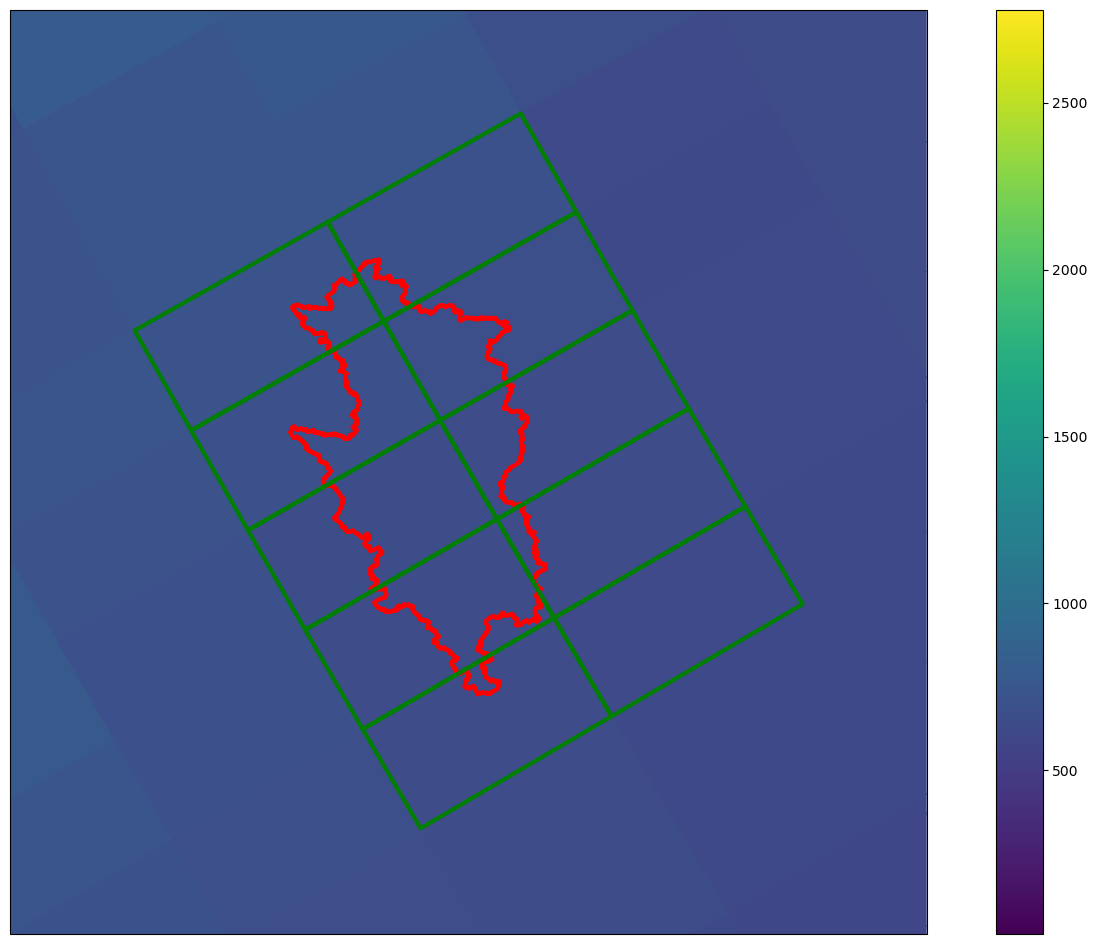

In [37]:
aea_crs = ccrs.AlbersEqualArea(central_longitude=100,
                               standard_parallels=(50, 70),
                               central_latitude=56,
                               false_easting=0,
                               false_northing=0)

merc_crs = ccrs.Mercator()

fig = plt.figure(figsize=(18, 12))
ax = plt.axes(projection=aea_crs)
# find extent coordinates
min_lon, max_lon, min_lat, max_lat = find_extent(ws=random_geom,
                                                 grid_res=0.125,
                                                 dataset='era5')
# W, E, S, N
ax.set_extent([min_lon-0.25, max_lon+0.25, min_lat-0.25, max_lat+0.25],
              crs=ccrs.PlateCarree())

fig = plt.pcolor(example_nc['lon'], example_nc['lat'],
                 example_nc * 1e3, 
                 shading='auto',
                 transform=ccrs.PlateCarree())

plt.colorbar(fig)

ax.add_geometries([random_geom],
                  crs=ccrs.PlateCarree(),
                  facecolor="None",
                  edgecolor='red',
                  linewidth=3)

ax.add_geometries([poly for poly in poly_weights['geometry']],
                  crs=ccrs.PlateCarree(),
                  facecolor="None",
                  edgecolor='green',
                  linewidth=3)
ax.patch.set_alpha(0)

plt.show()

In [38]:
(masked_nc * 1e3).to_netcdf('../paper_visualisation/weight_mask/example_nc.nc')
ws_gdf.to_file('../paper_visualisation/weight_mask/actual_ws.gpkg')
poly_weights.to_file('../paper_visualisation/weight_mask/weights_mask.gpkg')


### Cringe Q(h) relation

In [61]:
from datetime import datetime

def get_season(value: datetime) -> int:
    """[summary]

    Args:
        value (datetime): [description]

    Returns:
        int: [description]
    """
    month = value.month
    if month in range(3, 6):
        season = 1
    elif month in range(6, 9):
        season = 2
    elif month in range(9, 12):
        season = 3
    else:
        season = 4
    return season

In [63]:
test_gauge = pd.read_csv('../geo_data/great_db/ais_data/q_h/7036.csv')
test_gauge['date'] = pd.to_datetime(test_gauge['date'])
test_gauge = test_gauge.set_index('date')
plot_df = test_gauge[['lvl_sm', 'q_cms_s']]
plot_df['doy'] = plot_df.index.day_of_year
plot_df['year'] = plot_df.index.year
plot_df['season'] = [get_season(i) for i in plot_df.index]

/tmp/ipykernel_445550/1870167201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['doy'] = plot_df.index.day_of_year


In [65]:
plot_df['season'] != 4

date
2008-01-01    False
2008-01-02    False
2008-01-03    False
2008-01-04    False
2008-01-05    False
              ...  
2020-12-27    False
2020-12-28    False
2020-12-29    False
2020-12-30    False
2020-12-31    False
Name: season, Length: 4749, dtype: bool

In [69]:
year_df = plot_df[(plot_df['year'] == i) &\
            ((plot_df['season'] != 4) & plot_df['season'] != 3)]
year_df

lvl_sm  q_cms_s  doy  year  season
date                                          
2020-03-01   216.0     14.5   61  2020       1
2020-03-02   216.0     14.5   62  2020       1
2020-03-03   216.0     14.4   63  2020       1
2020-03-04   216.0     14.4   64  2020       1
2020-03-05   216.0     14.4   65  2020       1
...            ...      ...  ...   ...     ...
2020-08-27   224.0     95.0  240  2020       2
2020-08-28   227.0    101.0  241  2020       2
2020-08-29   227.0    101.0  242  2020       2
2020-08-30   228.0    102.0  243  2020       2
2020-08-31   236.0    118.0  244  2020       2

[184 rows x 5 columns]

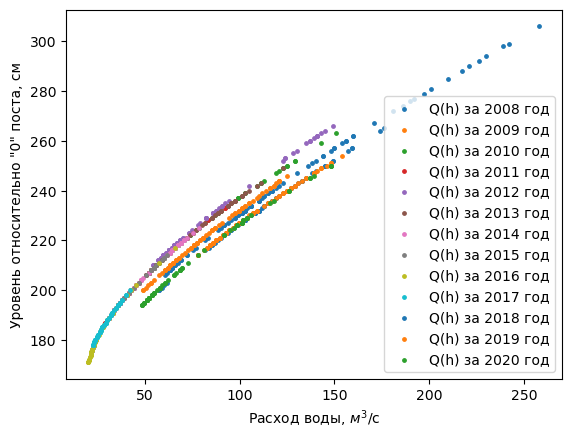

In [83]:
for i in range(2008, 2021):
    # if i == 2017:
    year_df = plot_df[plot_df['year'] == i]
    year_df = year_df[[True
                        if i not in [1, 3, 4]
                        else False for i in year_df['season']]]
    plt.scatter(x=year_df['q_cms_s'], y=year_df['lvl_sm'],
                s=6, label=f'Q(h) за {i} год');
    plt.xlabel('Расход воды, $м^3$/с')
    plt.ylabel('Уровень относительно "0" поста, см')
    plt.legend()

In [57]:
plot_df[plot_df['year'] == 2020]['lvl_sm']

date
2020-01-01    221.0
2020-01-02    221.0
2020-01-03    220.0
2020-01-04    220.0
2020-01-05    219.0
              ...  
2020-12-27    283.0
2020-12-28    284.0
2020-12-29    285.0
2020-12-30    285.0
2020-12-31    285.0
Name: lvl_sm, Length: 366, dtype: float64